# Scraping geographical data

In this section we import some information about Swiss cities (geo-coordinates, population) using the *Requests* library.

First parsing of geographical cordinates. WARN: invalid key reported. The output is a geography.csv file, containing the cities' name and coordinates (latitude, longitude).

In [12]:
dictionary = {}
cities = data.lieu.value_counts().index
import googlemaps
gmaps = googlemaps.Client(key='***')

In [1]:
for city in cities:
    geocode_result = gmaps.geocode(city)
    if (len(geocode_result)>0):
        coord = [geocode_result[0]['geometry']['location']['lat'],geocode_result[0]['geometry']['location']['lng']]
        dictionary[city]=coord
    else:
        dictionary[city]='nan'

In [59]:
latitude = []
longitude = []
for city in cities:
    latitude.append(dictionary[city][0])
    longitude.append(dictionary[city][1])
geography = pd.DataFrame({'city' : data.lieu, 'latitude' : latitude, 'longitude' : longitude})
geography.to_csv('geography.csv')

Second part: compute the degree distance between each city and Lausanne as an extremely rough estimation of the physical distance (rescaled by the Earth's radius). Save the output into geodistance.csv.

In [78]:
cities = pd.read_csv('geography.csv',encoding = 'latin1')
del cities['Unnamed: 0']

In [81]:
# get distances in degrees
import math
center = [46.5196535,6.6322734]
distance = []
for city in cities.index:
    if (cities.latitude.loc[city] not in ['n','nan']):
        lat_dist = float(cities.latitude.loc[city])-center[0]
        lng_dist = float(cities.longitude.loc[city])-center[1]
        distance.append(math.sqrt(lat_dist*lat_dist+lng_dist*lng_dist))
    else:
        distance.append(np.nan)
cities['distance']=distance
cities.to_csv('geodistance.csv',encoding='latin1')

Add to the dataset the number of runners participating to the Lausanne's Marathon as an additional column and save into geoinfo.csv.

In [82]:
cities = pd.read_csv('geodistance.csv',encoding='latin1')
del cities['Unnamed: 0']

In [83]:
runners_per_city = data.lieu.value_counts()
population = []
for city in cities.city:
    k = 0
    while (k < len(cities)) and (runners_per_city.index[k]!=city):
        k +=1
    population.append(runners_per_city[runners_per_city.index[k]])

In [84]:
cities['runners']=population

In [85]:
cities.to_csv('geoinfo.csv',encoding='latin1')

Plot the distance distribution. We observe a scale-invariant trend for small values. The highest numbers represent runners coming from far away Countries in the world (degree distance).

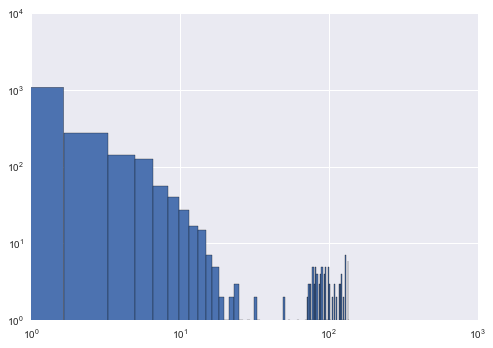

In [86]:
cities.distance.hist(bins=100)
plt.xscale('log')
plt.yscale('log')

# Scraping population data

In this section we try to map each city contained in geoinfo.csv with its overall population. We scrape the population information from the following Wikipedia [page](https://en.wikipedia.org/wiki/List_of_cities_in_Switzerland).

In [3]:
geoinfo = pd.read_csv('geoinfo.csv',encoding='latin1')
del geoinfo['Unnamed: 0']
geoinfo.head(5)

,city,latitude,longitude,distance,runners
0,St-Légier-La Chiésaz,46.47171849999999,6.876770899999999,0.249152,12
1,St-Légier,46.47171849999999,6.876770899999999,0.249152,57
2,Ernen,46.39850010000001,8.1457733,1.518341,1
3,Lausanne,46.5196535,6.6322734,0.000000,2043
4,Pully,46.5092681,6.6654949,0.034807,312


In [4]:
import requests
url = 'https://en.wikipedia.org/wiki/List_of_cities_in_Switzerland'
r = requests.get(url)
table = pd.read_html(r.text)
table = table[1]

We are interested in the second table, which provides the relevant information. We import city name, Canton and Population for eventual visualization purposes.

In [5]:
city = table[0][2:]
city = city.reset_index(range(len(city)))
city = city.rename(columns={0 : 'name'})
del city['index']
canton = table[3][2:]
canton = canton.reset_index(range(len(city)))
canton = canton.rename(columns={3 : 'canton'})
del canton['index']
population = table[4][2:]
population = population.reset_index(range(len(city)))
population = population.rename(columns={4 : 'population'})
del population['index']

pop = pd.DataFrame()
pop['city']=city
pop['canton']=canton
pop['population']=population

In [6]:
pop.head()

,city,canton,population
0,Aarau,AG,20710
1,Aarberg,BE,4529
2,Aarburg,AG,7723
3,Adliswil,ZH,18551
4,Aesch (BL)[note 1],BL,10198


Try to link each city in *cities* with the names in *pop* through a suitable dictionary:

In [7]:
mapping = {}
for city in geoinfo.city:
    k = 0
    length = len(pop)
    while (k < length) and ((city in pop.city[k])!=True):
        k = k+1
    if k==length:
        mapping[city]='nan'
    else:
        mapping[city]=k

In [8]:
population = []
canton = []
for city in geoinfo.city:
    if mapping[city]=='nan':
        population.append('nan')
        canton.append('nan')
    else:
        population.append(pop.population[mapping[city]])
        canton.append(pop.canton[mapping[city]])
geoinfo['population']=population
geoinfo['canton']=canton

In [9]:
geoinfo.to_csv('complete_geography.csv',encoding='latin1')